# comma package tutorial

In [1]:
from comma.model import Model
from comma import create_empty_hypotheses
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)
np.random.seed(0)
dir_params = '../parameters/'

### Step 1. Initialise the model


In [76]:
model = Model()

### Step 2. Generate n individuals by sampling from the IPF weights (previously computed in R)

Note that if you wish to generate a population based on parameters specified in `params_individual.json` simply set `use_ipf` to `False`. This will initiate a sampling from the distribution outlined in the json file, which does *not* take into account the joint probabilities within variables. Only the `use_ipf` set to `True` will sample with replacement from a distribution whereby the joint probabilities between variables is accounted for. 

In [77]:
size = 25
individuals = model.setup(size, '../parameters/', use_ipf=True) 

Populating individuals: 100%|█████████████████| 25/25 [00:00<00:00, 13219.57i/s]


### Step 3. Run the model

In [78]:
steps = 100

n = steps // 4
lockdown_pattern = ["absent"]*n + ["medium"]*n + ["hard"]*n + ["easy"]*n
model.run(steps=steps, lockdown=lockdown_pattern, out_path="simulation_results.csv")

Running simulation: 100%|█████████████████████| 100/100 [00:07<00:00, 14.00it/s]


The model at the end of the run will output "simulation_results.csv". 

### Step 4. Plot the results

In [79]:
data = pd.read_csv('simulation_results.csv', delimiter=";", decimal=",")

In [80]:
display(data.head())

,step_id,lockdown,agent_id,delta_mental_health,cumulative_mental_health
0,0,absent,0,0.0,0.004
1,0,absent,1,0.0,0.002
2,0,absent,2,0.0,0.005
3,0,absent,3,0.0,0.004
4,0,absent,4,0.0,0.002


#### Group by step_id and compute the average mental health score

In [81]:
grouped_data = data.groupby(['step_id', 'lockdown']).mean().reset_index()
grouped_data

,step_id,lockdown,agent_id,delta_mental_health,cumulative_mental_health
0,0,absent,12.0,0.00000,0.002840
1,1,absent,12.0,0.00248,0.003191
2,2,absent,12.0,0.00256,0.003672
3,3,absent,12.0,0.00288,0.004641
4,4,absent,12.0,0.00304,0.005543
...,...,...,...,...,...
95,95,easy,12.0,0.00224,-0.020339
96,96,easy,12.0,0.00188,-0.020254
97,97,easy,12.0,0.00184,-0.020394
98,98,easy,12.0,0.00192,-0.020352


### Cumulative mental health across time per agent

In [82]:
agg_df = data.groupby(['step_id', 'lockdown'])['cumulative_mental_health'].mean().reset_index()
agg_df['label'] = 'average mental health'

few_points = data[data['agent_id'] <= 3]
other_points = data[data['agent_id'] > 3]

max_step_ids = data.groupby('lockdown')['step_id'].max().reset_index()


In [83]:
# Create a dictionary with a unique color for each agent_id
colors = {}
unique_agents = data['agent_id'].unique()
for agent in unique_agents:
    if agent <= 3:
        colors[agent] = {0: "#386cb0", 1: "#fdb462", 2: "#7fc97f", 3: "darkred"}[agent]
    else:
        colors[agent] = "gainsboro"


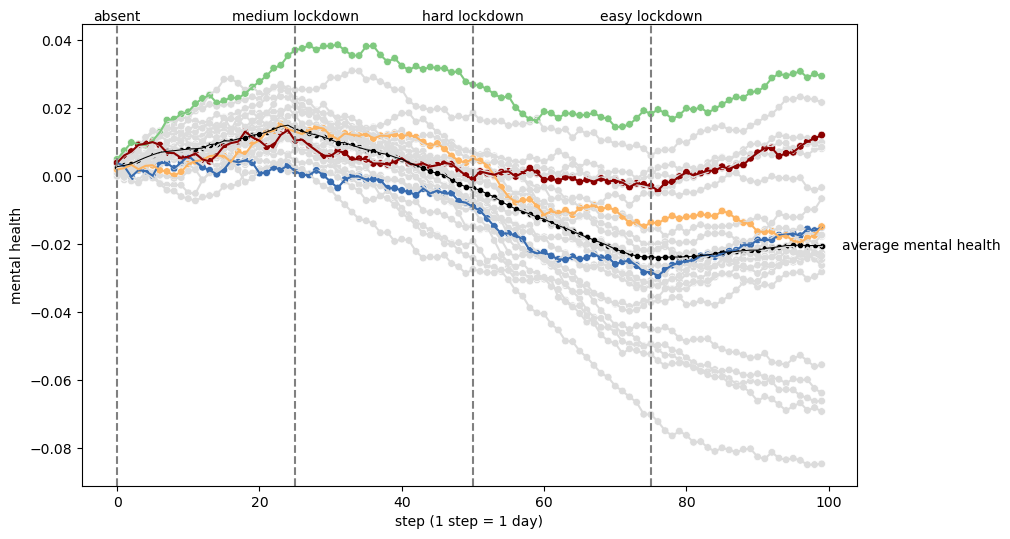

In [92]:

fig, ax = plt.subplots(figsize=(10, 6))

# other_points
sns.lineplot(data=other_points, x='step_id', y='cumulative_mental_health', hue='agent_id', palette=colors, legend=False)
sns.scatterplot(data=other_points, x='step_id', y='cumulative_mental_health', hue='agent_id', palette=colors, s=30, legend=False)

# few_points
sns.lineplot(data=few_points, x='step_id', y='cumulative_mental_health', hue='agent_id', palette=colors, ax=ax)
sns.scatterplot(data=few_points, x='step_id', y='cumulative_mental_health', hue='agent_id', palette=colors, s=30, ax=ax)

# agg_df
sns.lineplot(data=agg_df, x='step_id', y='cumulative_mental_health', color='black', ax=ax, size=2)
sns.scatterplot(data=agg_df, x='step_id', y='cumulative_mental_health', color='black', s=20, ax=ax)

# add lockdown labels and dotted lines
for x_val, label in zip([0, 25, 50, 75], ['absent', 'medium lockdown', 'hard lockdown', 'easy lockdown']):
    ax.axvline(x=x_val, linestyle='--', color='gray')
    ax.text(x=x_val, y=ax.get_ylim()[1], s=label, va='bottom', ha='center')

avg_mh_text_y = agg_df[agg_df['step_id'] == agg_df['step_id'].max()]['cumulative_mental_health'].values[0]
ax.text(113, avg_mh_text_y, 'average mental health', va='center', ha='center', color='black')

ax.set_xlabel('step (1 step = 1 day)')
ax.set_ylabel('mental health')
ax.get_legend().remove()

plt.show()


### Average mental health for each step coloured by lockdown type

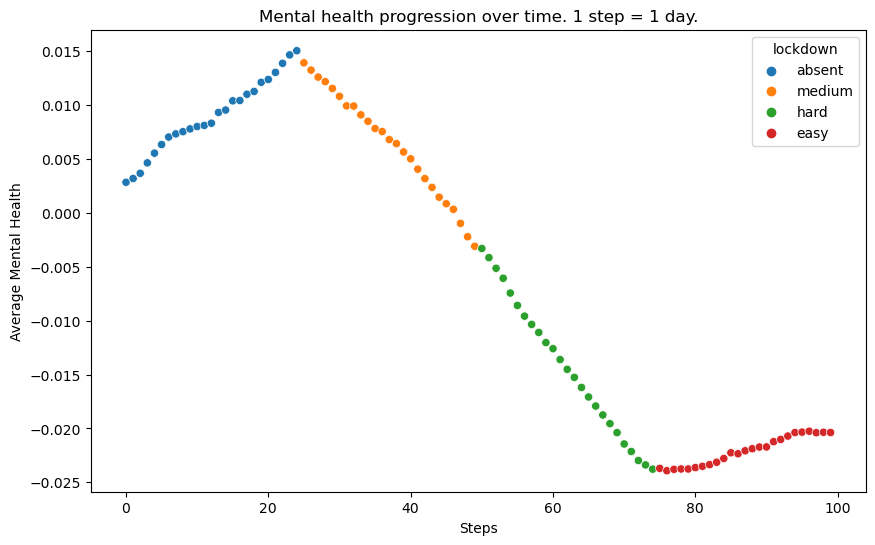

In [85]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=grouped_data, x='step_id', y='cumulative_mental_health', hue='lockdown')
plt.xlabel('Steps')
plt.ylabel('Average Mental Health')
plt.title('Mental health progression over time. 1 step = 1 day.')
plt.show()